In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [18]:
ds = tfds.load("fashion_mnist", split="train")

In [19]:
dsiter = ds.as_numpy_iterator()

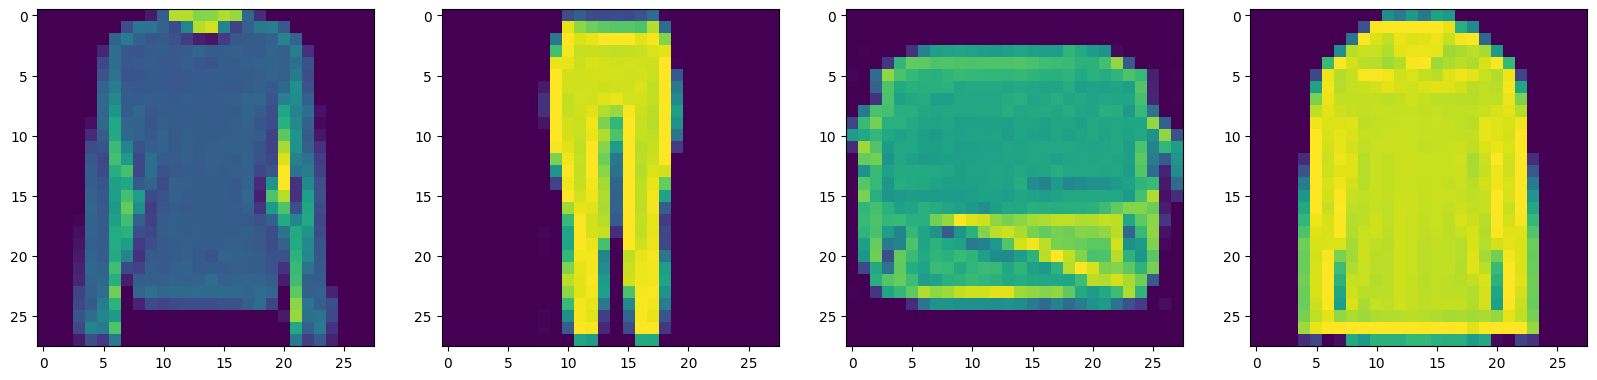

In [20]:
fig, ax = plt.subplots(ncols=4, figsize= (20,20))
for i in range(4):
    batch = dsiter.next()
    ax[i].imshow(np.squeeze(batch["image"]))

In [21]:
def scaleimage(data):
    image = data["image"]
    return  image/255

In [22]:
ds = tfds.load("fashion_mnist", split="train")
ds = ds.map(scaleimage)
ds = ds.cache()
ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [23]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [24]:
def buildgenerator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,4,padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1,4,padding="same", activation="sigmoid"))
    return model

In [25]:
generator = buildgenerator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [26]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 132ms/step


(4, 28, 28, 1)

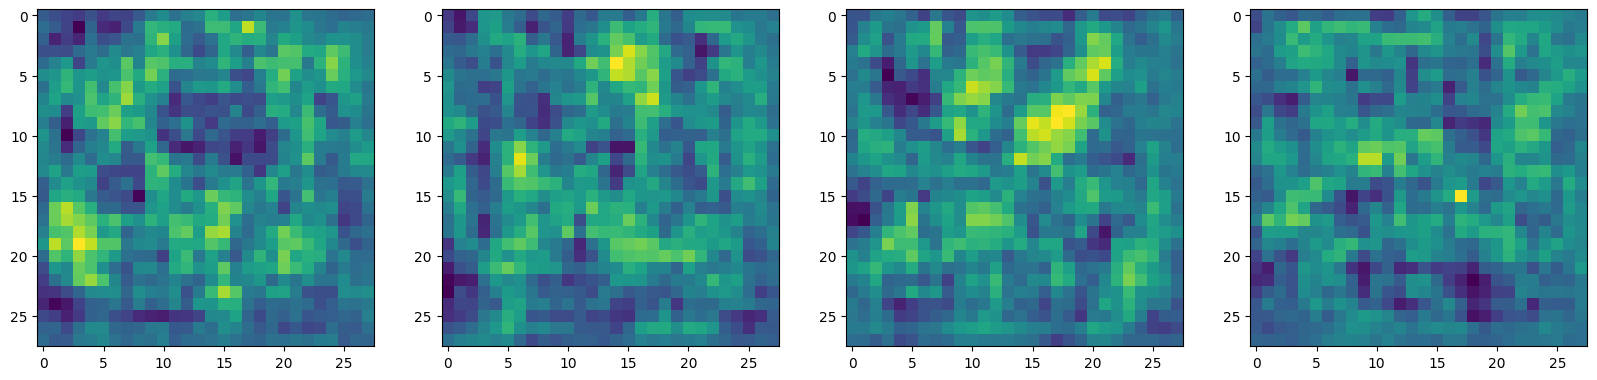

In [27]:
fig, ax = plt.subplots(ncols=4, figsize= (20,20))
for i, img in enumerate(img):
    ax[i].imshow(np.squeeze(img))

In [28]:
def builddiscriminator():
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [29]:
discriminator = builddiscriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [32]:
gopt = Adam(learning_rate=0.0001)
dopt = Adam(learning_rate=0.00001)
gloss = BinaryCrossentropy()
dloss = BinaryCrossentropy()

In [38]:
class gan(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
    def compile(gopt, dopt, gloss, dloss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.gopt = gopt
        self.dopt = dopt
        self.gloss = gloss
        self.dloss = dloss
        pass
    def trainstep(self, batch):
        realimages = batch
        fakeimages = self.generator(tf.random.normal((128,128,1)), training = False)
        with tf.GradientTape as tape:
            ycapreal = self.discriminator(realimages, training= True)
            ycapfake = self.discriminator(fakeimages, training= True)
            ycaprealfake = tf.concat([ycapreal, ycapfake], axis = 0)
            yrealfake = tf.concat([tf.zeros_like(ycapreal), tf.ones_like(ycapfake)], axis=0)

            noisereal = 0.15 * tf.random.uniform(tf.shape(ycapreal))
            noisefake = -0.15 * tf.random.uniform(tf.shape(ycapfake))
            yrealfake += tf.concat([noisereal, noisefake], axis = 0)
            totaldloss = self.dloss(yrealfake, ycaprealfake)
        dgrad = tape.gradient(totaldloss, self.discriminator.trainable_variables)
        self.dopt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        with tf.GradientTape as gtape:
            genimages = self.generator(tf.random.normal((128,128,1)), training = True)
            predlabels = self.discriminator(genimages, training = False )
            totalgloss = self.gloss(tf.zeros_like(predlabels), predlabels)
            ggrad = ftape.